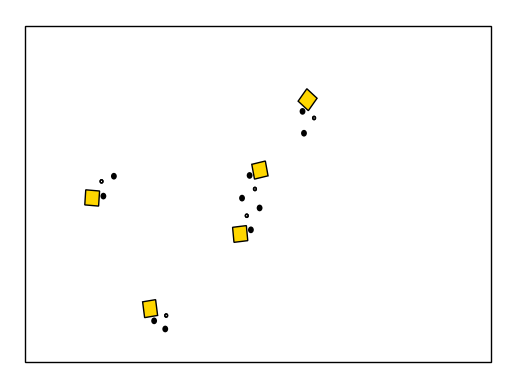

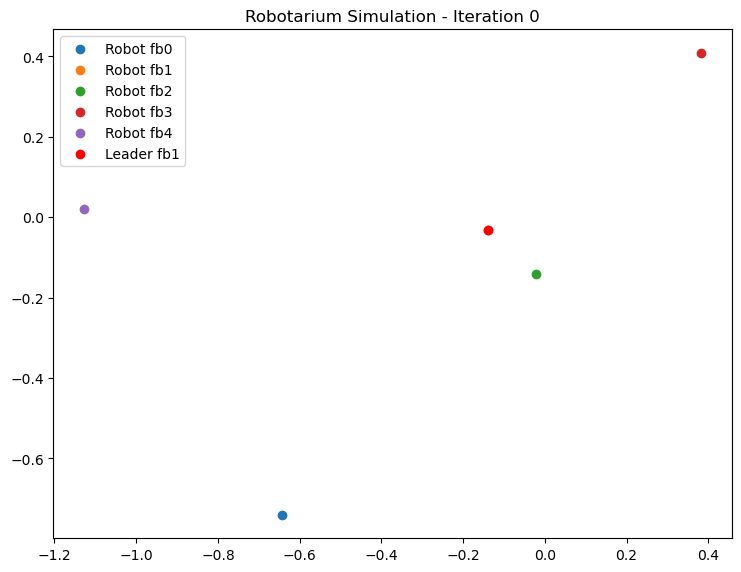

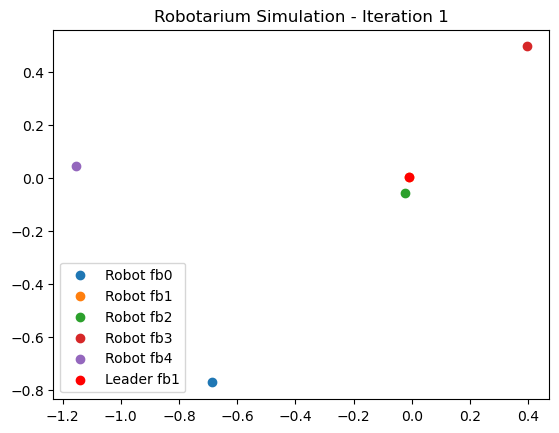

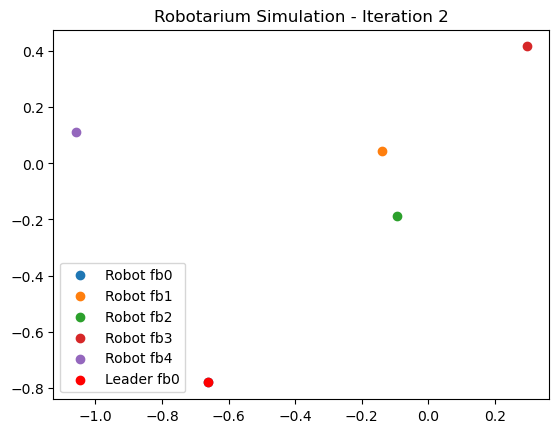

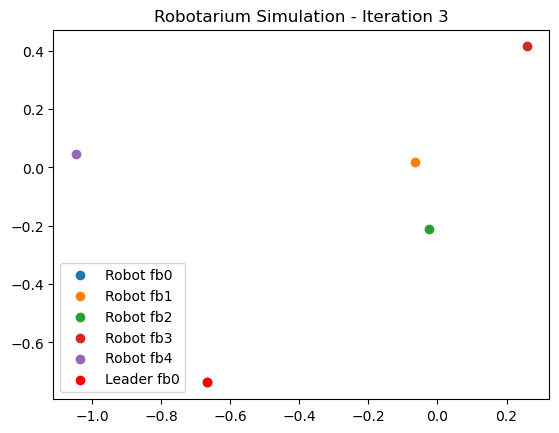

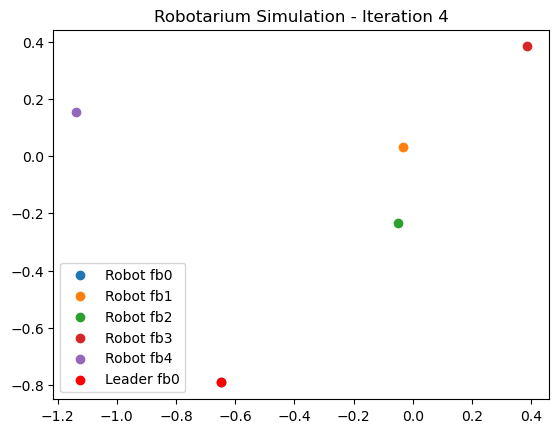

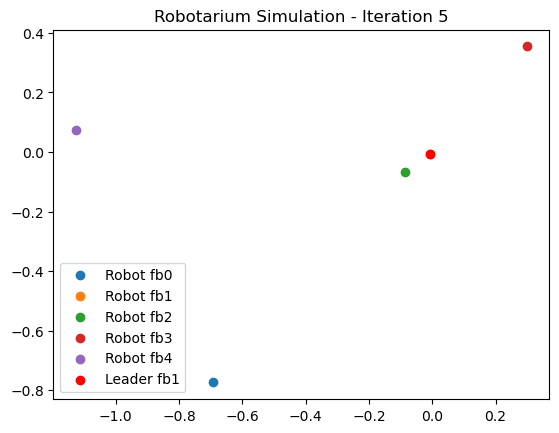

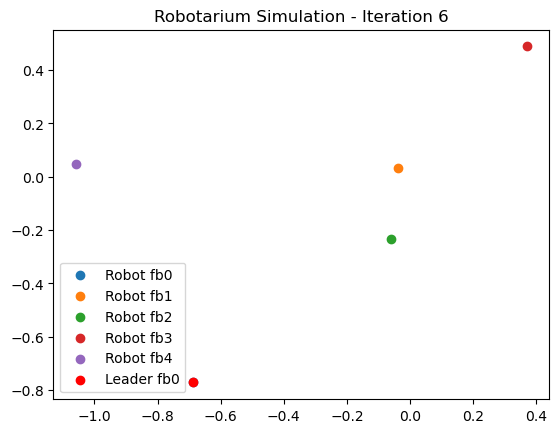

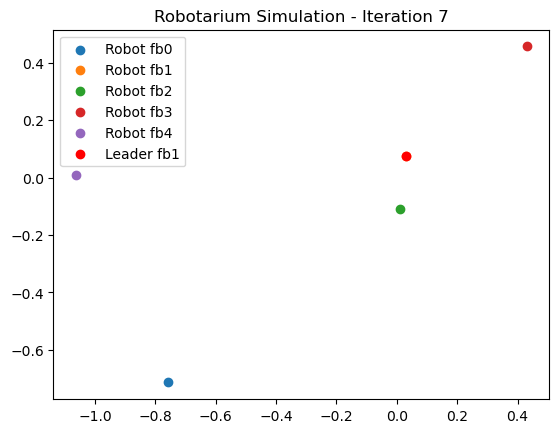

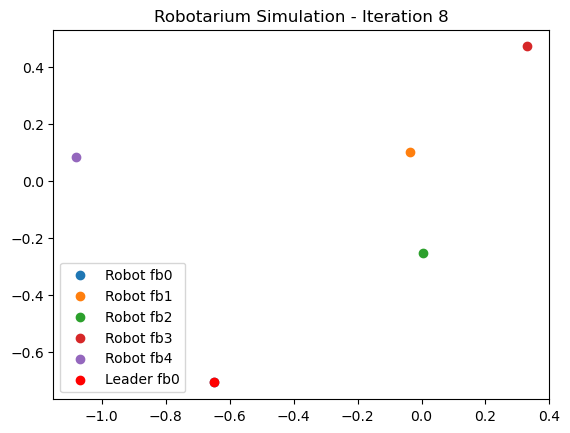

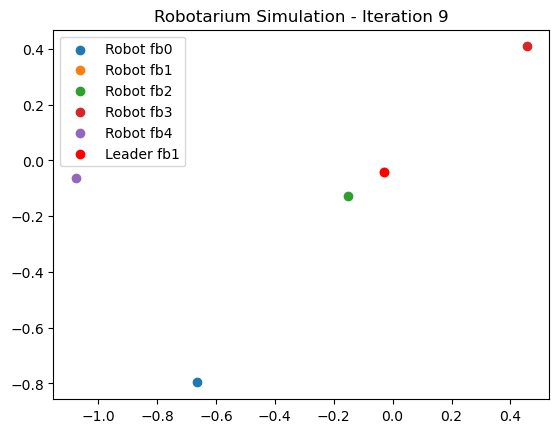

Mean Squared Error (MSE): 1.2505543937919692


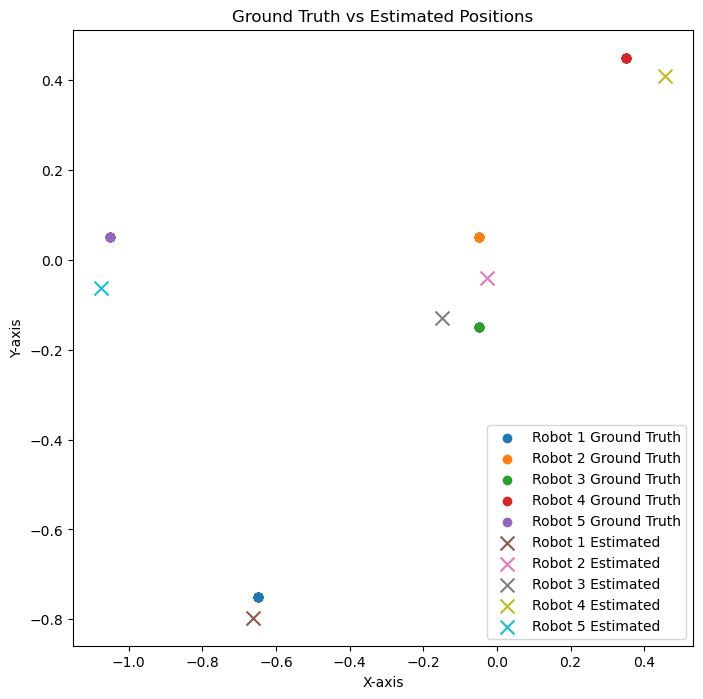

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from rps.robotarium import Robotarium
import math

num_robots = 5
bounding_box = [-1.5, 1.5, -1.5, 1.5]
communication_range = 0.2
num_iterations = 10
std_noise = 0.05  # Standard deviation of noise

class Robot:
    def __init__(self, robot_id, x, y):
        self.id = robot_id
        self.x = x
        self.y = y
        self.leader_id = None
        self.neighbors = []
        self.leader_bid = 0

    def update_neighbors(self, all_robots):
        self.neighbors = [robot for robot in all_robots if robot.id != self.id and self.distance_to(robot) <= communication_range]

    def distance_to(self, other_robot):
        return math.sqrt((self.x - other_robot.x)**2 + (self.y - other_robot.y)**2)

class RobotariumExtended(Robotarium):
    def __init__(self, number_of_robots, show_figure=True, std_noise=0.05):  # Pass std_noise as a parameter
        self.num_robots = number_of_robots
        self.std_noise = std_noise  # Store std_noise
        super().__init__(number_of_robots, show_figure)
        self.robots = []
        self.true_positions = {}
        self.initialize_robots()
        self.leader = self.leader_election()

    def initialize_robots(self):
        for i in range(self.num_robots):
            x = np.random.uniform(bounding_box[0], bounding_box[1])
            y = np.random.uniform(bounding_box[2], bounding_box[3])
            robot = Robot("fb" + str(i), x, y)
            self.robots.append(robot)
            self.true_positions[robot.id] = (x, y)

    def leader_election(self):
        for robot in self.robots:
            robot.update_neighbors(self.robots)
            robot.leader_bid = len(robot.neighbors)
        leader = max(self.robots, key=lambda x: x.leader_bid)
        leader.leader_id = leader.id
        return leader
    
r = RobotariumExtended(number_of_robots=num_robots, show_figure=True, std_noise=std_noise)

ground_truth_poses = []
relative_positions = []
errors = []
leader_data = []
reference_robot_data = []
leader_changes = []

for iteration in range(num_iterations):
    poses = r.get_poses()
    ground_truth_poses.append(poses.copy())

    relative_pos = []
    for i, robot in enumerate(r.robots):
        robot.x, robot.y = poses[0, i], poses[1, i]
        rel_x = robot.x - r.leader.x
        rel_y = robot.y - r.leader.y
        relative_pos.append((rel_x, rel_y))
    
    relative_positions.append(relative_pos)

    error = np.linalg.norm(np.array(poses[:2]) - np.array([[robot.x], [robot.y]])).max()
    errors.append(error)
    for robot in r.robots:
        robot.update_neighbors(r.robots)
    for robot in r.robots:
        velocity = np.random.normal(0, r.std_noise, size=(2,))  # Apply noise using normal distribution
        robot.x += velocity[0]
        robot.y += velocity[1]
    
    r.leader = r.leader_election()

    plt.clf()
    for robot in r.robots:
        plt.scatter(robot.x, robot.y, label=f'Robot {robot.id}')

    plt.scatter(r.leader.x, r.leader.y, color='red', label=f'Leader {r.leader.id}')
    
    plt.legend()
    plt.title(f'Robotarium Simulation - Iteration {iteration}')
    plt.pause(0.1)
    r.step()
    leader_data.append((r.leader.x, r.leader.y))
    reference_robot_data.append((r.robots[0].x, r.robots[0].y))

ground_truth_poses = np.array(ground_truth_poses)
ground_truth_poses_flat = ground_truth_poses.reshape(-1, num_robots * 2)
estimated_poses_flat = np.array([[robot.x, robot.y] for robot in r.robots]).flatten()

mse = np.mean((estimated_poses_flat - ground_truth_poses_flat)**2)
print(f'Mean Squared Error (MSE): {mse}')

plt.figure(figsize=(8, 8))
for i in range(num_robots):
    plt.scatter(ground_truth_poses[:, 0, i], ground_truth_poses[:, 1, i], label=f'Robot {i+1} Ground Truth')

# Plot estimated positions
for i, robot in enumerate(r.robots):
    plt.scatter(robot.x, robot.y, marker='x', s=100, label=f'Robot {i+1} Estimated')

plt.legend()
plt.title('Ground Truth vs Estimated Positions')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()


